<a href="https://colab.research.google.com/github/MohuaSinha/EVA4/blob/master/S12/Assignment%20A/S12_TinyImageNet_ResNet18_Main2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library'
sys.path.append(workingdir)

In [3]:
ls-ltr

total 8
drwxr-xr-x 1 root root 4096 Apr  3 16:24 sample_data/
drwx------ 4 root root 4096 Apr 20 19:49 gdrive/


In [4]:
%matplotlib inline
import torch
import torchvision
import numpy as np


#Below are the created modules
import dnnmodel
import custom_resnet
import train_test
import datatransformation 
import showimages
import displayimages
import gradcam 
import grad_visualize 
from lrfinder import LRFinder
import lr_range_test
from clr import CyclicLR
from utils import *
import plotresults
from torch.optim.lr_scheduler import StepLR
import datapreparation

  pip install torch-lr-finder -v --global-option="amp"


In [5]:
classes, trainloader, testloader = datapreparation.load('tinyimagenet', 70, batch_size=512, split=True, albumentations=True)


CUDA Available? True


shape: torch.Size([512, 3, 64, 64])
n04417672 n01945685 n01950731 n04099969 n04486054


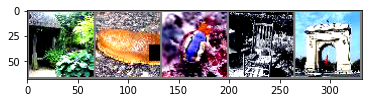

In [6]:
#display.show_random_images(trainloader, classes, 5)
displayimages.show_random_image(trainloader,classes)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = dnnmodel.ResNet18(num_classes=200)
model = net.to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

#LR Finder Test
criterion = nn.CrossEntropyLoss()
weight_decay = 5e-4

#criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader,testloader, start_lr=1e-5, end_lr=2, num_iter=10, step_mode="exp")
#lr_finder.range_test(trainloader, testloader, start_lr=1e-4, end_lr=0.02,epochs=50, step_mode="linear")
#lr_finder.range_test(trainloader,testloader, start_lr=1e-5, end_lr=0.02, step_mode="exp")
# num_iter=len(trainloader),


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


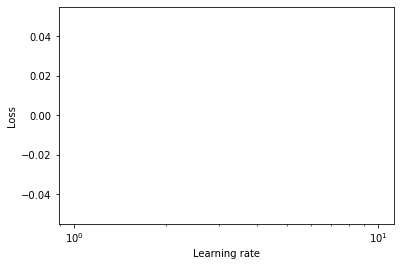

In [15]:
lr_finder.plot()
lr_finder.reset()

In [0]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

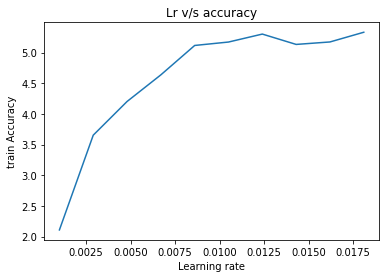

In [16]:
#LR Range Test
best_lr=0.0013410137474136339
max_lr = 0.02
min_lr = 0.001
lr_rangetest_epoch = 10
lr_range_test.LR_test(max_lr, min_lr, device, lr_rangetest_epoch, model, criterion, trainloader, momemtum = 0.9, weight_decay=0.05, plot= True)

In [17]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau

initial_lr = 0.001
max_lr = best_lr
min_lr = max_lr * 0.01

EPOCHS = 50
steps_per_epoch = len(trainloader)
num_steps = steps_per_epoch * EPOCHS
peak_lr_epoch = 5 
pct_start = float (peak_lr_epoch/EPOCHS)
div_factor = float (max_lr/initial_lr)
final_div_factor = float (initial_lr/min_lr)

print("maxlr: ", max_lr)
print("epochs: ", EPOCHS)
print("steps_per_epoch: ", steps_per_epoch)
print("pct_start: ", pct_start)
print("div_factor: ", div_factor)
print("final_div_factor: ", final_div_factor)

#torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=None, epochs=None, steps_per_epoch=None, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, last_epoch=-1)

optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
#scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(trainloader),epochs=args.epochs, div_factor=10, final_div_factor=1,
                      # pct_start=5/args.epochs, anneal_strategy="linear")

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr, 
                                                epochs=EPOCHS, 
                                                steps_per_epoch=steps_per_epoch, 
                                                pct_start=pct_start, 
                                                anneal_strategy='cos', 
                                                cycle_momentum=True, 
                                                base_momentum=0.85, 
                                                max_momentum=0.95, 
                                                div_factor=div_factor, 
                                                final_div_factor=final_div_factor, 
                                                last_epoch=-1)


input_size=(3,32,32)

maxlr:  0.0013410137474136339
epochs:  50
steps_per_epoch:  151
pct_start:  0.1
div_factor:  1.3410137474136339
final_div_factor:  74.57045104337408


In [0]:
def run(l1_decay=0.0, l2_decay=0.0):
  train_losses=[]
  test_losses = []
  train_accs=[]
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  LR_list = []
  EPOCHS = 50
  #args.epochs
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
      LR_list.append(optimizer.param_groups[0]['lr'])
      train_test.train(model, device, trainloader, optimizer,scheduler, epoch,False,best_loss=0)
      train_test.test(model, device, testloader,criterion, classes, test_losses, test_accs,misclassified_imgs,correct_imgs,epoch==EPOCHS-1)        
      #scheduler.step()

In [0]:
# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs,correct_imgs = run(l1_decay=3e-06, l2_decay=0.001)

  0%|          | 0/151 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.001


Loss=4.896554946899414 Batch_id=150 Accuracy=2.73: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0096, Accuracy: 1625/33000 (4.92%)

EPOCH: 1 LR: 0.001


Loss=4.497564315795898 Batch_id=150 Accuracy=6.81: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0089, Accuracy: 2646/33000 (8.02%)

EPOCH: 2 LR: 0.001


Loss=4.294294834136963 Batch_id=150 Accuracy=10.22: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0083, Accuracy: 3764/33000 (11.41%)

EPOCH: 3 LR: 0.001


Loss=3.970262050628662 Batch_id=150 Accuracy=13.39: 100%|██████████| 151/151 [02:13<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 4160/33000 (12.61%)

EPOCH: 4 LR: 0.001


Loss=4.016103744506836 Batch_id=150 Accuracy=15.89: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 5296/33000 (16.05%)

EPOCH: 5 LR: 0.001


Loss=3.565566062927246 Batch_id=150 Accuracy=18.21: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 5893/33000 (17.86%)

EPOCH: 6 LR: 0.001


Loss=3.611433506011963 Batch_id=150 Accuracy=20.18: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 6202/33000 (18.79%)

EPOCH: 7 LR: 0.001


Loss=3.3250327110290527 Batch_id=150 Accuracy=22.34: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 6766/33000 (20.50%)

EPOCH: 8 LR: 0.001


Loss=3.34330677986145 Batch_id=150 Accuracy=24.38: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 7085/33000 (21.47%)

EPOCH: 9 LR: 0.001


Loss=3.142012596130371 Batch_id=150 Accuracy=26.18: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0068, Accuracy: 7384/33000 (22.38%)

EPOCH: 10 LR: 0.001


Loss=2.9362595081329346 Batch_id=150 Accuracy=27.65: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0067, Accuracy: 7744/33000 (23.47%)

EPOCH: 11 LR: 0.001


Loss=3.008850336074829 Batch_id=150 Accuracy=29.67: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0063, Accuracy: 8714/33000 (26.41%)

EPOCH: 12 LR: 0.001


Loss=3.080092430114746 Batch_id=150 Accuracy=30.85: 100%|██████████| 151/151 [02:13<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0062, Accuracy: 9237/33000 (27.99%)

EPOCH: 13 LR: 0.001


Loss=2.9140148162841797 Batch_id=150 Accuracy=32.30: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0061, Accuracy: 9259/33000 (28.06%)

EPOCH: 14 LR: 0.001


Loss=2.7634592056274414 Batch_id=150 Accuracy=33.86: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 9623/33000 (29.16%)

EPOCH: 15 LR: 0.001


Loss=3.105105400085449 Batch_id=150 Accuracy=35.29: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0058, Accuracy: 10500/33000 (31.82%)

EPOCH: 16 LR: 0.001


Loss=2.7593326568603516 Batch_id=150 Accuracy=36.62: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0057, Accuracy: 10554/33000 (31.98%)

EPOCH: 17 LR: 0.001


Loss=2.537492513656616 Batch_id=150 Accuracy=38.10: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0057, Accuracy: 10729/33000 (32.51%)

EPOCH: 18 LR: 0.001


Loss=2.3245978355407715 Batch_id=150 Accuracy=39.06: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 10194/33000 (30.89%)

EPOCH: 19 LR: 0.001


Loss=2.491844654083252 Batch_id=150 Accuracy=40.55: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 10048/33000 (30.45%)

EPOCH: 20 LR: 0.001


Loss=2.5961310863494873 Batch_id=150 Accuracy=41.84: 100%|██████████| 151/151 [02:13<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 10983/33000 (33.28%)

EPOCH: 21 LR: 0.001


Loss=2.323749303817749 Batch_id=150 Accuracy=42.87: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0053, Accuracy: 11997/33000 (36.35%)

EPOCH: 22 LR: 0.001


Loss=2.283242702484131 Batch_id=150 Accuracy=43.98: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0058, Accuracy: 10382/33000 (31.46%)

EPOCH: 23 LR: 0.001


Loss=2.190391778945923 Batch_id=150 Accuracy=45.25: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 12257/33000 (37.14%)

EPOCH: 24 LR: 0.001


Loss=2.0271456241607666 Batch_id=150 Accuracy=46.40: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 12253/33000 (37.13%)

EPOCH: 25 LR: 0.001


Loss=2.11563777923584 Batch_id=150 Accuracy=47.51: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 11870/33000 (35.97%)

EPOCH: 26 LR: 0.001


Loss=2.1555910110473633 Batch_id=150 Accuracy=48.82: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 12650/33000 (38.33%)

EPOCH: 27 LR: 0.001


Loss=2.1286087036132812 Batch_id=150 Accuracy=49.97: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 12950/33000 (39.24%)

EPOCH: 28 LR: 0.001


Loss=2.071417808532715 Batch_id=150 Accuracy=50.90: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 12311/33000 (37.31%)

EPOCH: 29 LR: 0.001


Loss=1.9476624727249146 Batch_id=150 Accuracy=51.82: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 13081/33000 (39.64%)

EPOCH: 30 LR: 0.001


Loss=2.0555429458618164 Batch_id=150 Accuracy=53.29: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 11572/33000 (35.07%)

EPOCH: 31 LR: 0.001


Loss=1.8037796020507812 Batch_id=150 Accuracy=54.18: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 13037/33000 (39.51%)

EPOCH: 32 LR: 0.001


Loss=1.7420023679733276 Batch_id=150 Accuracy=55.25: 100%|██████████| 151/151 [02:13<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 12497/33000 (37.87%)

EPOCH: 33 LR: 0.001


Loss=1.7005702257156372 Batch_id=150 Accuracy=56.48: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 13161/33000 (39.88%)

EPOCH: 34 LR: 0.001


Loss=1.7259711027145386 Batch_id=150 Accuracy=57.56: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 12038/33000 (36.48%)

EPOCH: 35 LR: 0.001


Loss=1.5694198608398438 Batch_id=13 Accuracy=59.88:   9%|▉         | 14/151 [00:14<02:01,  1.13it/s]

GroundTruth:  n02906734 n03126707 n04254777 n02480495 n01910747
Predicted:  n02808440 n03126707 n04254777 n03404251 n01910747


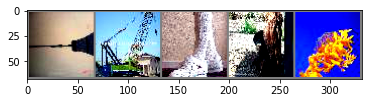

In [24]:
showimages.show_predicted_actual(model, device, testloader, classes)